# Energy consumption

# Energy consumption notebook

This Jupyter Notebook reads data for
1. Energy consumption
2. Water consumption
3. Oil consumption
from a Google Sheet.
The numbers in the sheet get updated on a monthly base.
The Juypter Notebook analyses this data and creates several visualisation to let us see the consumption compared on a yearly, monthly base and how it develops over time.

## ToDos
- [ ] prognose der Restlaufzeit mit derzeitigem Ölstand
- [ ] overview with the total energy consumption per year
- [ ] values in the plotbox for meridian and others

In [1]:
# import required libraries pandas, numpy, matplotlib, seaborn, datetime
from __future__ import print_function

import os.path

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import quickstart as qs
import locale


## General definitions


In [2]:
locale.setlocale(locale.LC_ALL, 'de_DE')

'de_DE'

## Read data from Google spreadsheet

In [9]:
# get a list of values for power, water and oil consumption from google sheets
values = qs.google_read_energy_power()
#convert list of values to pandas dataframe; first row is the header
#initially, df has the following columns: 'Strom (kwH)', 'Wasser (l)', 'Öl (l)', 'Monat', 'Jahr'
df = pd.DataFrame(values[1:], columns=values[0])

# Analyse the data

In [10]:
# print out the dimensions of the dataframe df
print(df.shape)
df.replace('', np.nan, inplace=True)
# check, how many cells per column do have invalid data
print(df.isnull().sum())

(135, 5)
Strom (kwH)              1
Wasser (l)               1
Laufzeit Brenner (h)    17
Monat                    0
Jahr                     0
dtype: int64


## Set create working dataframe and set column types


In [11]:
# define a new working dataframe as a copy of df
df_new = df.copy()
# change the headers of the columns in df_new
df_new.columns = ['power', 'water', 'boiler', 'month', 'year']
# set type of values in column 'power' to float
df_new['power'] = df_new['power'].astype(float)
# iterate over values in column 'power' until we find np.nan
for i in range(len(df_new['power'])):
    if np.isnan(df_new['power'][i]):
        if not np.isnan(df_new['power'][i-1]) and not np.isnan(df_new['power'][i+1]):
            #get the value from previous row and from next row
            power_mean_value = (df_new['power'][i-1] + df_new['power'][i+1])/2
            #locate the item, using .loc, in the dataframe in column power and replace it with the mean value
            df_new.loc[i, 'power'] = power_mean_value
        else:
            df_new.loc[i, 'power'] = 0
# add a new column 'power_per_month' to df_new, where the values are the differences of the values in column 'power'
df_new['power_per_month'] = df_new['power'].diff()

df_new['water'] = df_new['water'].astype(float)
for i in range(len(df_new['water'])):
    if np.isnan(df_new['water'][i]):
        if not np.isnan(df_new['power'][i-1]) and not np.isnan(df_new['power'][i+1]):
            #get the value from previous row and from next row
            water_mean_value = (df_new['water'][i-1] + df_new['water'][i+1])/2
            #locate the item, using .loc, in the dataframe in column power and replace it with the mean value
            df_new.loc[i, 'water'] = water_mean_value
        else:
            df_new.loc[i, 'water'] = 0
# add a new column 'water_per_month' to df_new, where the values are the differences of the values in column 'water'
df_new['water_per_month'] = df_new['water'].diff()

df_new['boiler'] = df_new['boiler'].astype(float)
for i in range(len(df_new['boiler'])):
    # check, if the value in column 'oil' at index i-1 is np.nan and that this index exists

    if np.isnan(df_new['boiler'][i]):
        if i > 0 and not np.isnan(df_new['boiler'][i-1]) and not np.isnan(df_new['boiler'][i+1]):
            #get the value from previous row and from next row
            water_mean_value = (df_new['boiler'][i-1] + df_new['boiler'][i+1])/2
            #locate the item, using .loc, in the dataframe in column power and replace it with the mean value
            df_new.loc[i, 'boiler'] = water_mean_value
        else:
            df_new.loc[i, 'boiler'] = 0
# add a new column 'water_per_month' to df_new, where the values are the differences of the values in column 'water'
df_new['boiler_per_month'] = df_new['boiler'].diff()

# add a new column 'date', which is the concatenation of the values in column 'month' and 'year'
df_new['date'] = df_new['month'] + '.' + df_new['year']
# convert the values in column 'date' (%B.%Y) to datetime format, where day is the last day of the month
df_new['date'] = pd.to_datetime(df_new['date'], format='%B.%Y')
# set the day of the timestamp in column 'date' to the last day of the month
df_new['date'] = df_new['date'] + pd.offsets.MonthEnd(0)

#df_new['month'] = df_new['month'].replace({'Januar':0, 'Februar':1, 'März':2, 'April':3, 'Mai':4, 'Juni':5, 'Juli':6,'August':7, 'September':8, 'Oktober':9, 'November':10, 'Dezember':11})
#make df_new['month'] categorical
df_new['month'] = df_new['month'].astype('category')
months = ["Januar", "Februar", "März", "April", "Mai", "Juni", 
          "Juli", "August", "September", "Oktober", "November", "Dezember"]
df_new['month'] = pd.Categorical(df_new['month'], categories=months, ordered=True)

Exclude the Outliers in a Column

In [12]:

lower = df_new.water_per_month.quantile(.02)
upper = df_new.water_per_month.quantile(.98)

df_new.water_per_month = df_new.water_per_month.clip(lower=lower, upper=upper)

boiler_lower = df_new.boiler_per_month.quantile(.05)
boiler_upper = df_new.boiler_per_month.quantile(.95)

df_new.boiler_per_month = df_new.boiler_per_month.clip(lower=boiler_lower, upper=boiler_upper)

## Show power consumption over time

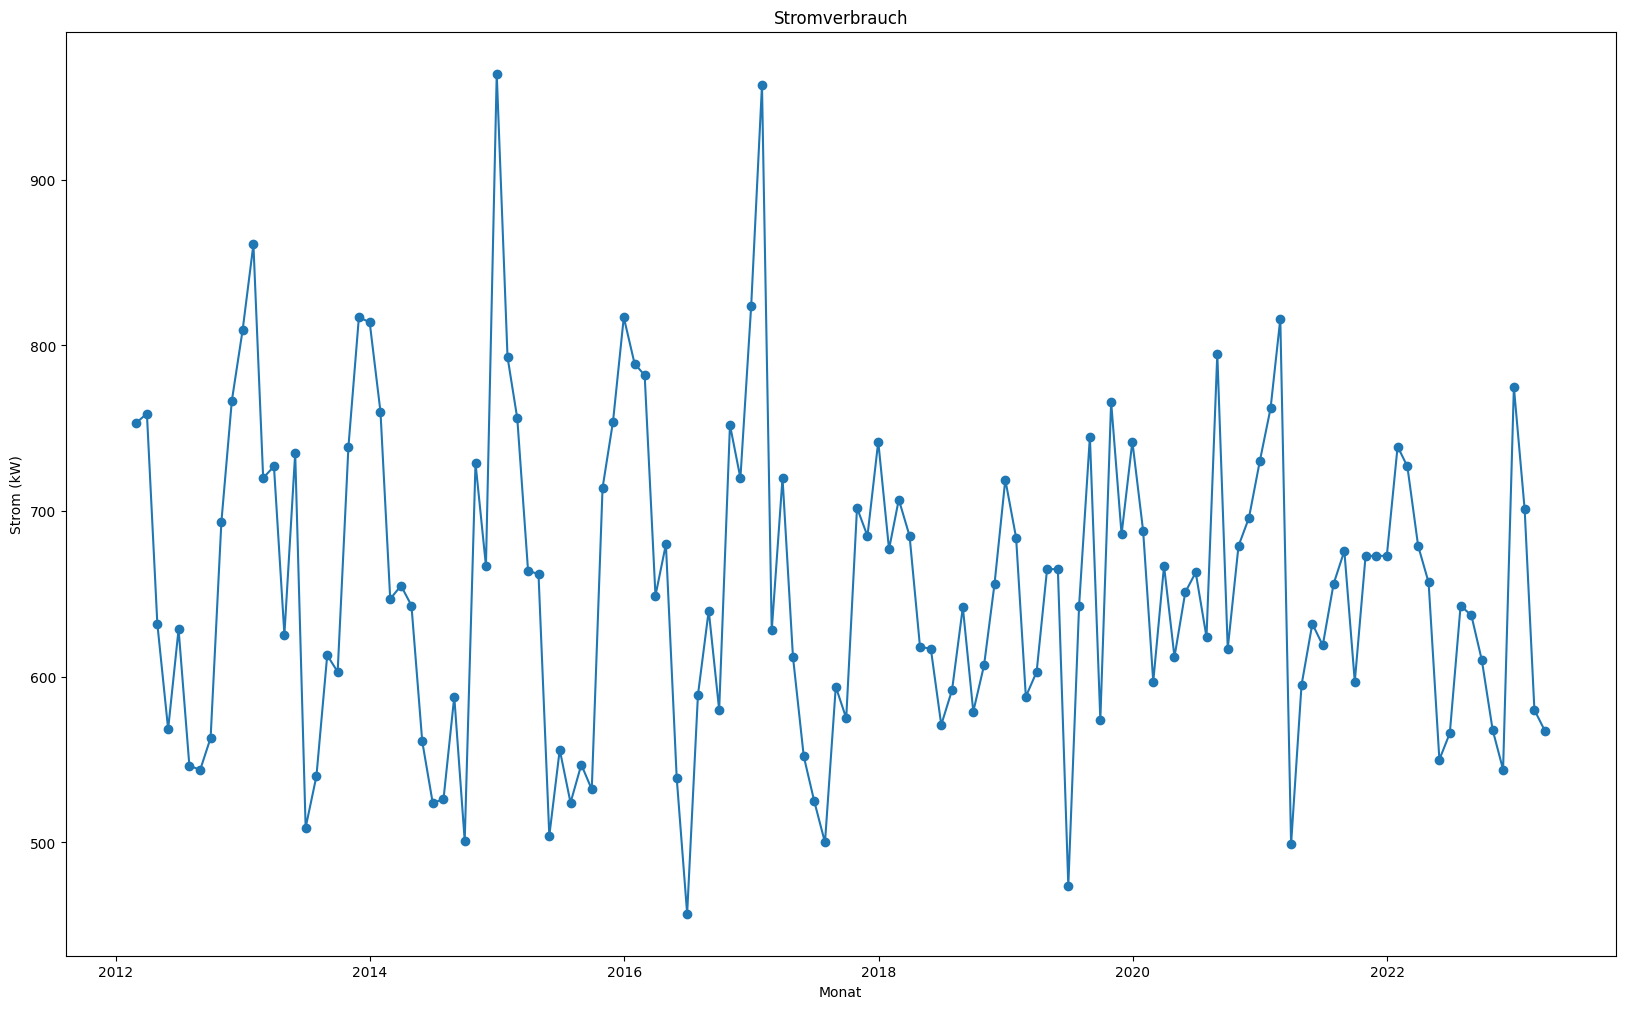

In [13]:
# draw a diagram that shows the power consumption per month
# create a new figure
fig = plt.figure(figsize=(20, 12))
# add a subplot (1 row, 1 column, 1st plot)
ax = fig.add_subplot(1, 1, 1)
# plot the data for the month in 2017
#ax.plot(df_new.loc[df_new['year'] == '2017', 'month'], df_new.loc[df_new['year'] == '2017', 'power_per_month'], 'o')
ax.plot(df_new['date'], df_new['power_per_month'], 'o-')
# set the x-axis label
ax.set_xlabel('Monat')
# set the y-axis label
ax.set_ylabel('Strom (kW)')
# set the title
ax.set_title('Stromverbrauch')
# show the plot
plt.show()


## Show water consumption per month

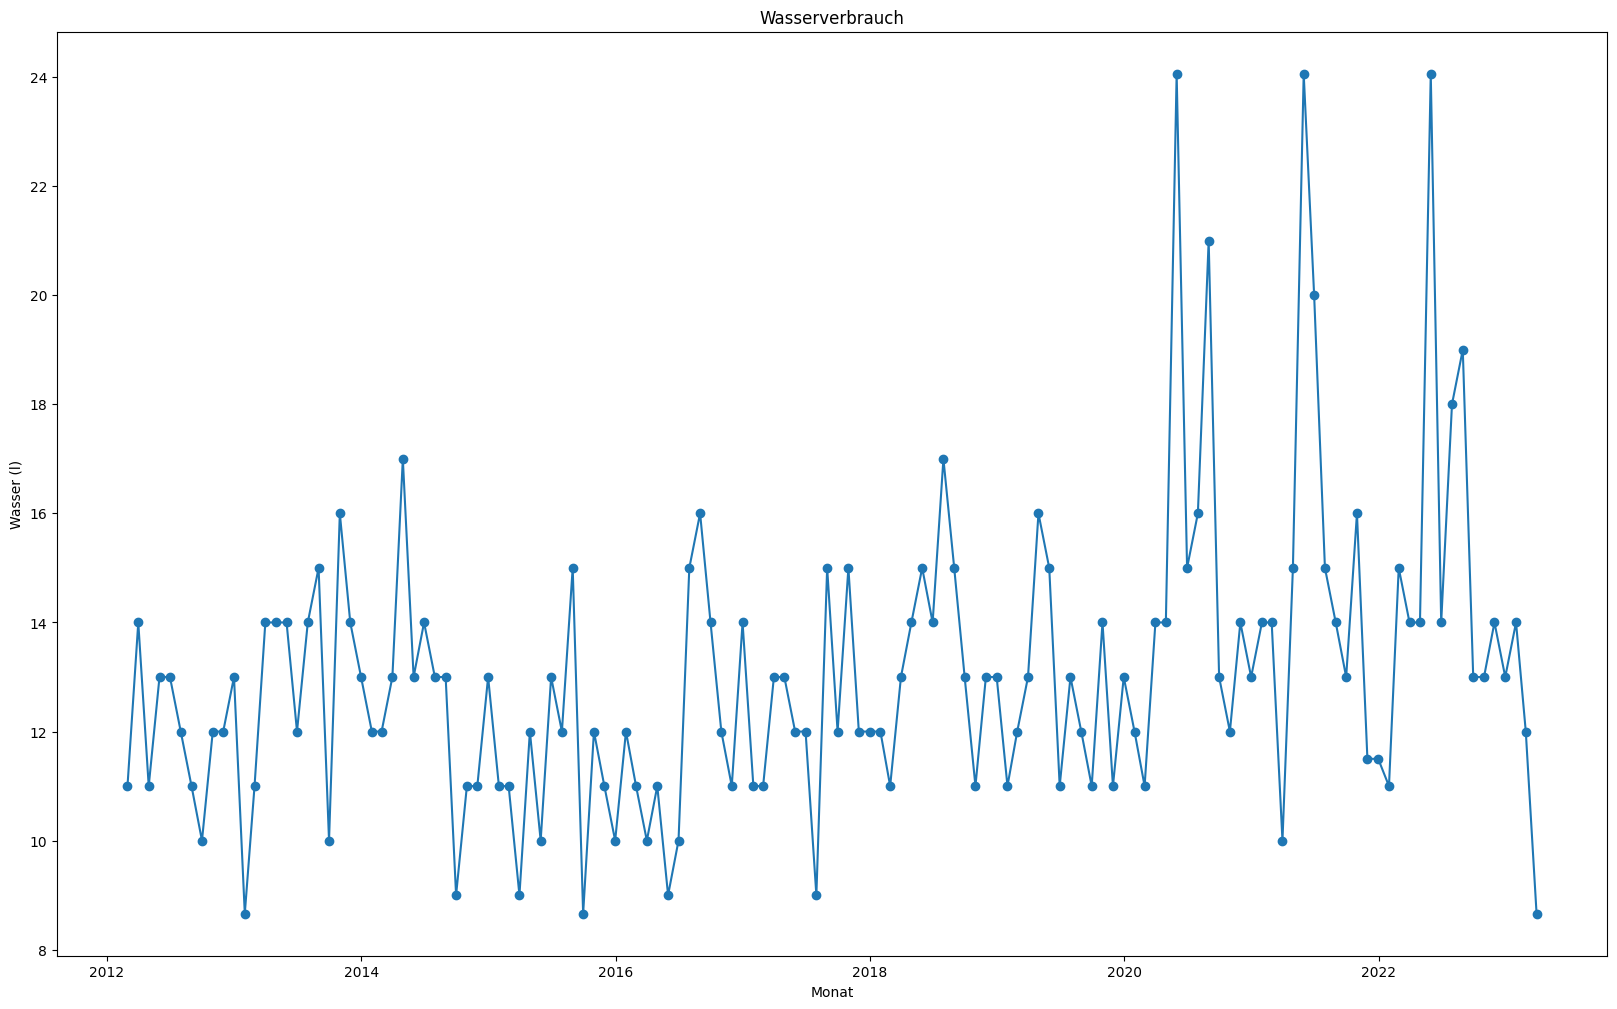

In [14]:
# draw a diagram that shows the power consumption per month
# create a new figure
fig = plt.figure(figsize=(20, 12))
# add a subplot (1 row, 1 column, 1st plot)
ax = fig.add_subplot(1, 1, 1)
# plot the data for the month in 2017
#ax.plot(df_new.loc[df_new['year'] == '2017', 'month'], df_new.loc[df_new['year'] == '2017', 'power_per_month'], 'o')
ax.plot(df_new['date'], df_new['water_per_month'], 'o-')
# set the x-axis label
ax.set_xlabel('Monat')
# set the y-axis label
ax.set_ylabel('Wasser (l)')
# set the title
ax.set_title('Wasserverbrauch')
# show the plot
plt.show()


## Show boiler runtime per month

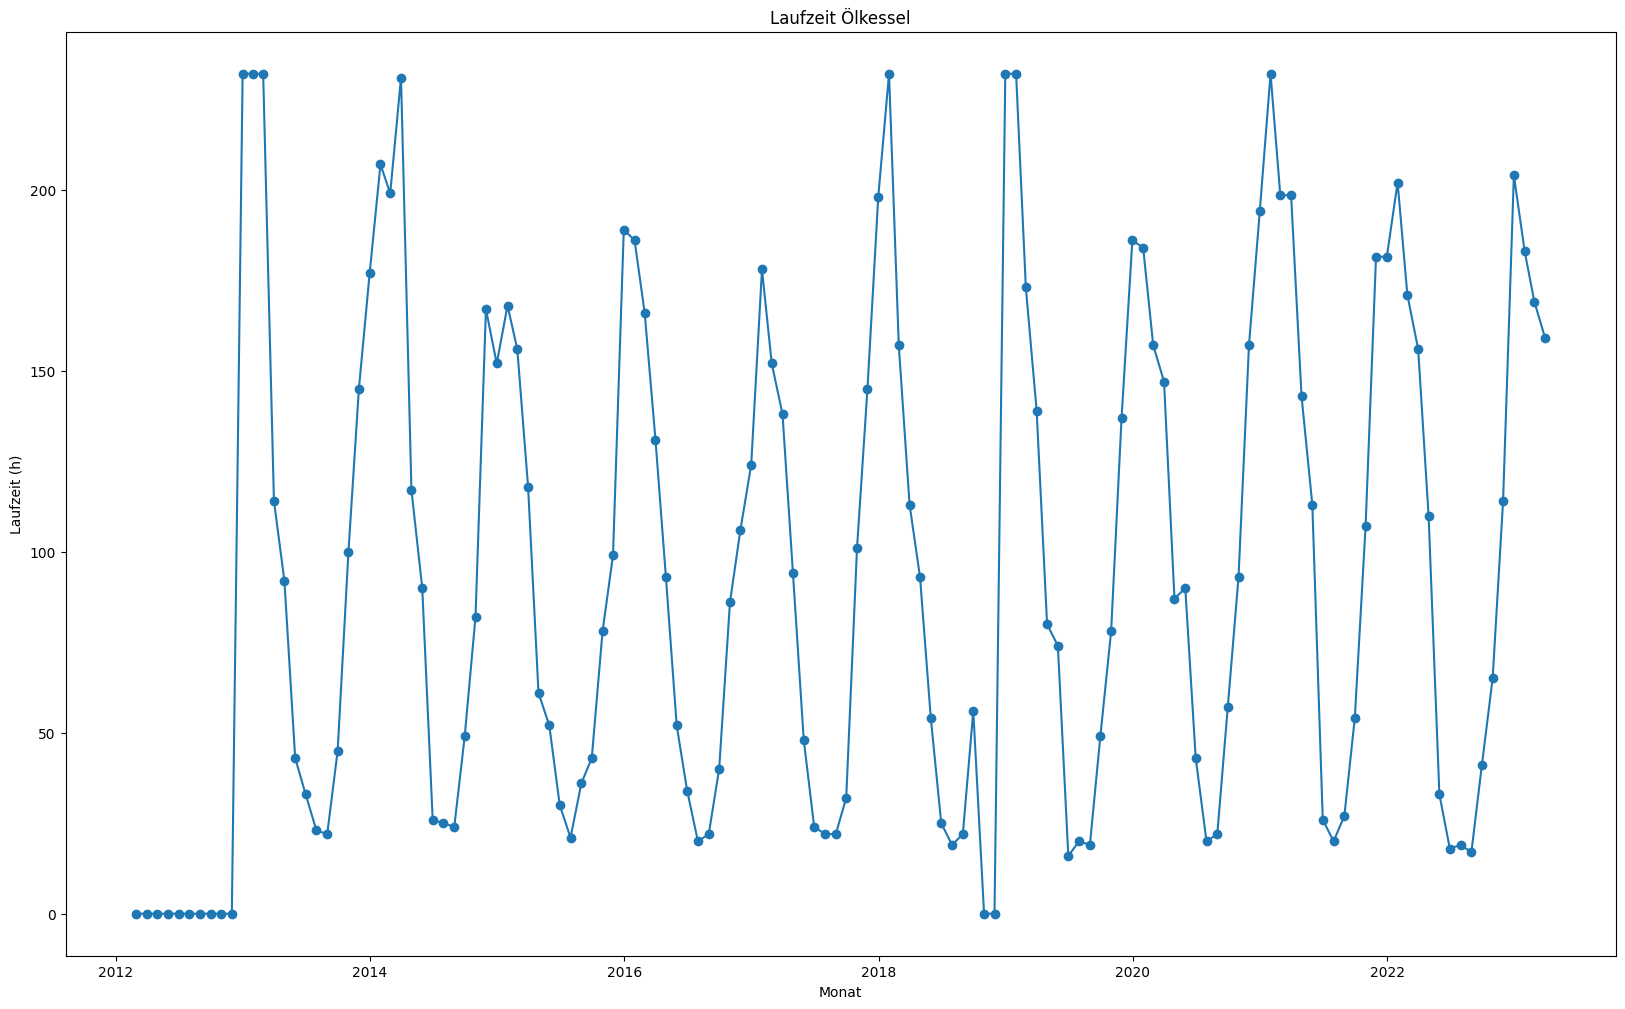

In [15]:
# draw a diagram that shows the power consumption per month
# create a new figure
fig = plt.figure(figsize=(20, 12))
# add a subplot (1 row, 1 column, 1st plot)
ax = fig.add_subplot(1, 1, 1)
# plot the data for the month in 2017
#ax.plot(df_new.loc[df_new['year'] == '2017', 'month'], df_new.loc[df_new['year'] == '2017', 'power_per_month'], 'o')
ax.plot(df_new['date'], df_new['boiler_per_month'], 'o-')
# set the x-axis label
ax.set_xlabel('Monat')
# set the y-axis label
ax.set_ylabel('Laufzeit (h)')
# set the title
ax.set_title('Laufzeit Ölkessel')
# show the plot
plt.show()

## A Boxplot, that shows the minimum and maximum values of energy consumption per month

<AxesSubplot: title={'center': 'power_per_month'}, xlabel='month'>

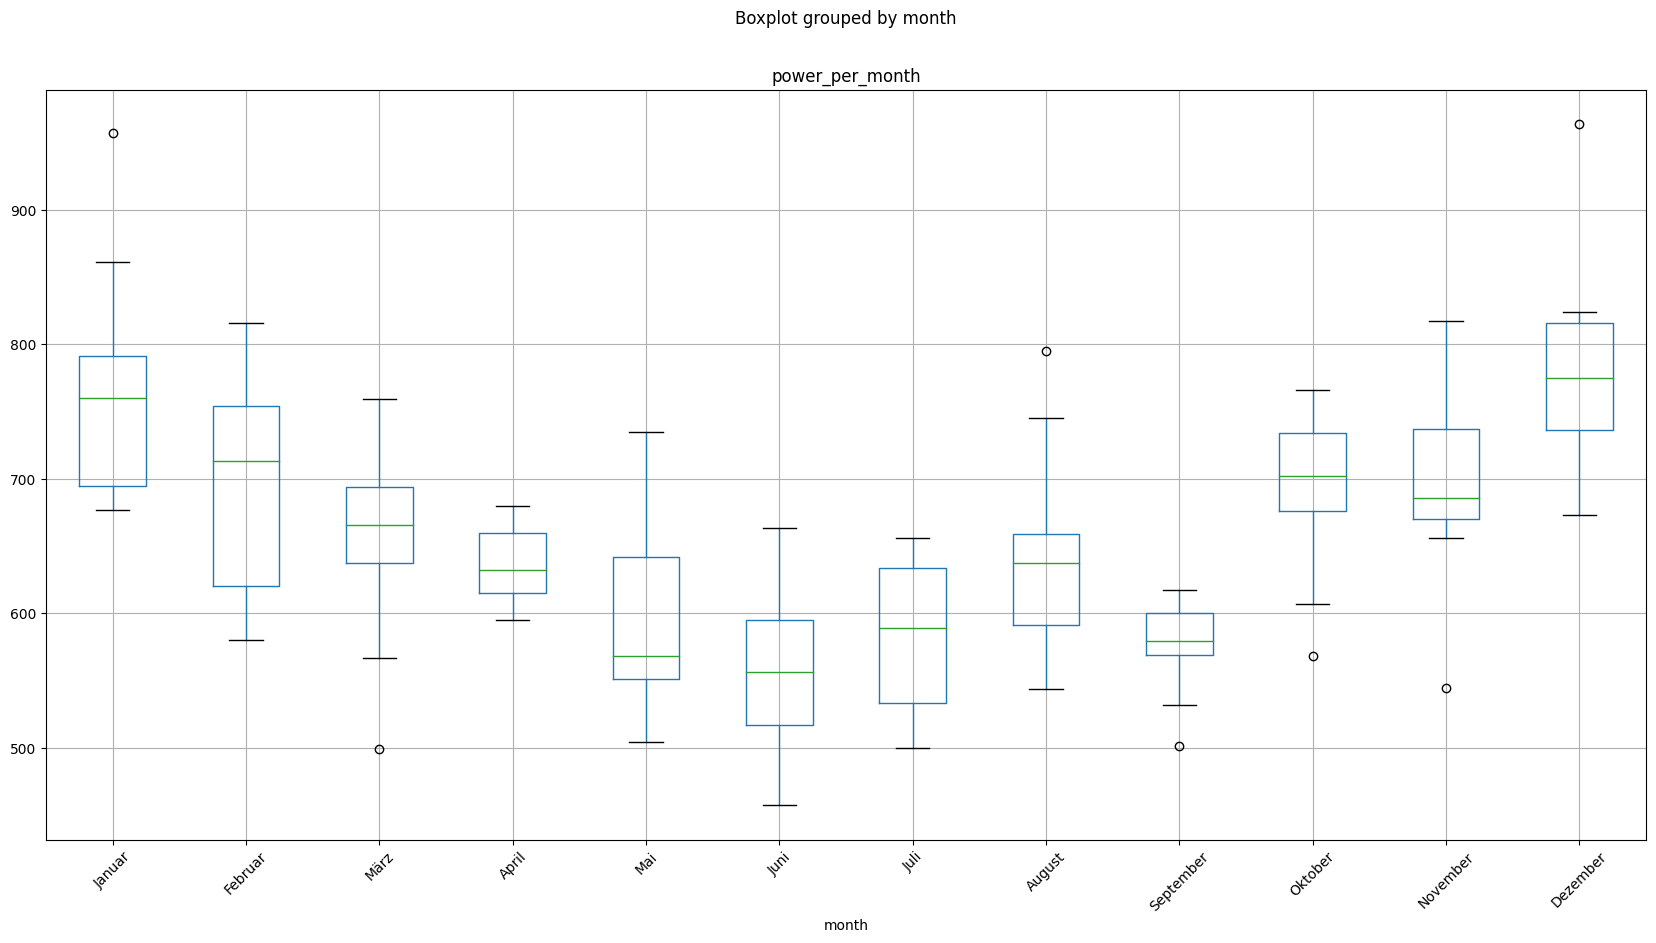

In [16]:
df_new.boxplot(by='month', column =['power_per_month'], grid = True, rot=45, figsize=(20,10))


## A Boxplot, that shows the minimum and maximum values of water consumption per month

<AxesSubplot: title={'center': 'water_per_month'}, xlabel='month'>

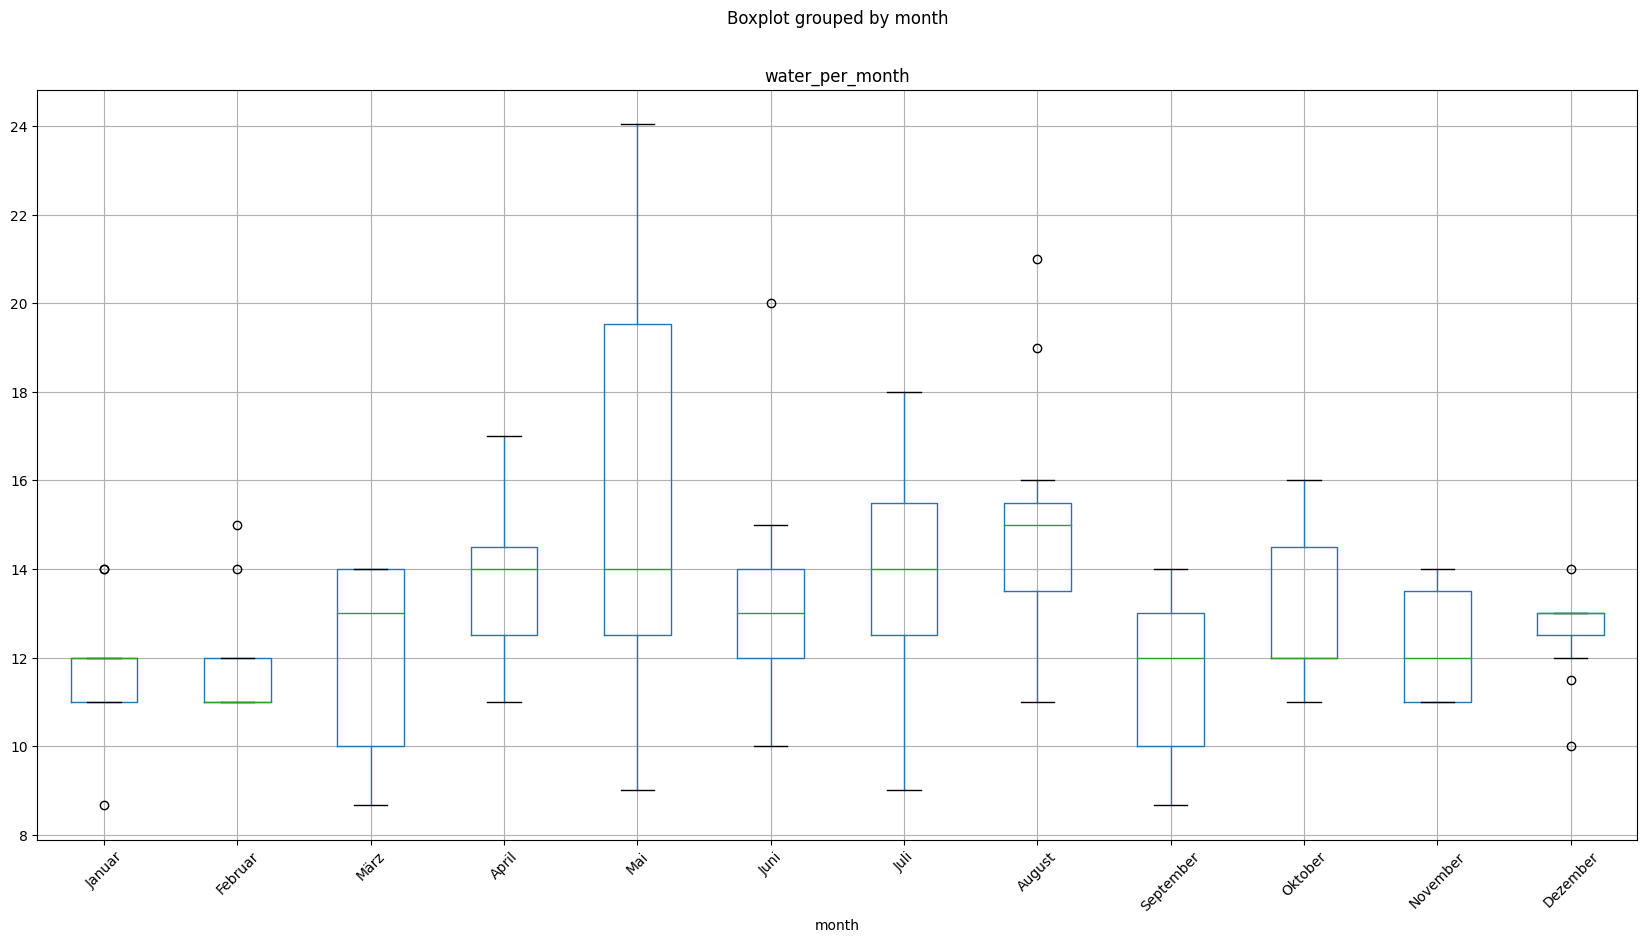

In [17]:
df_new.boxplot(by='month', column =['water_per_month'], grid = True, rot=45, figsize=(20,10))


## A Boxplot, that shows the minimum and maximum values of boiler runtime per month

<AxesSubplot: title={'center': 'boiler_per_month'}, xlabel='month'>

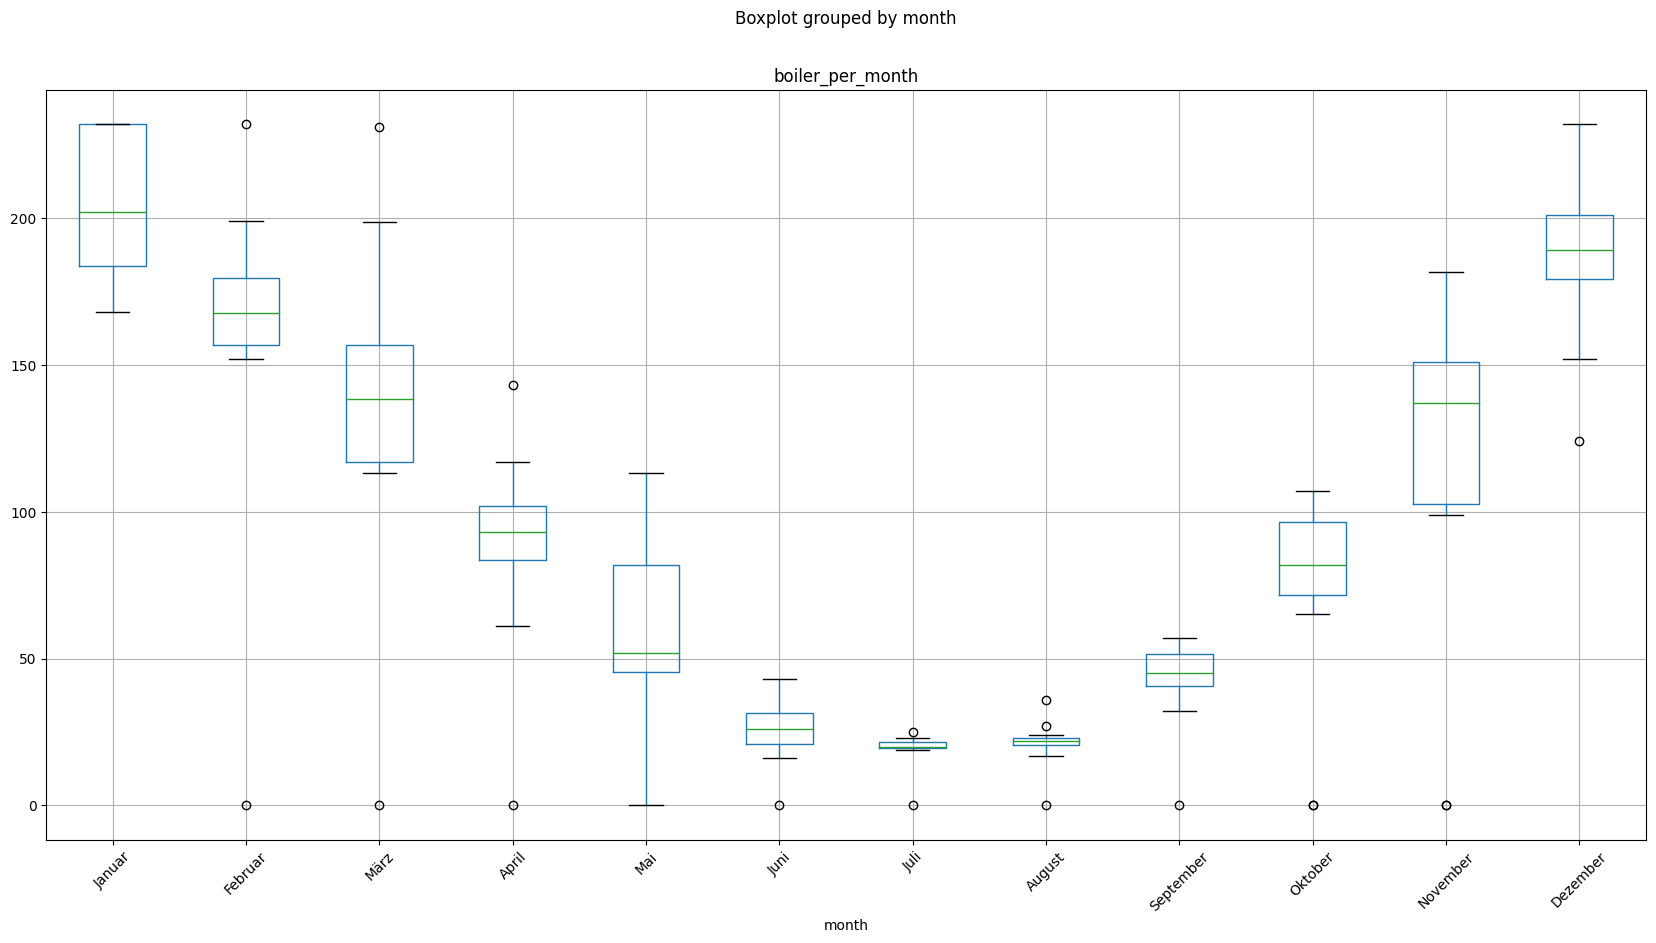

In [18]:
df_new.boxplot(by='month', column =['boiler_per_month'], grid = True, rot=45, figsize=(20,10))

## Heatmap for the energy consumption per month

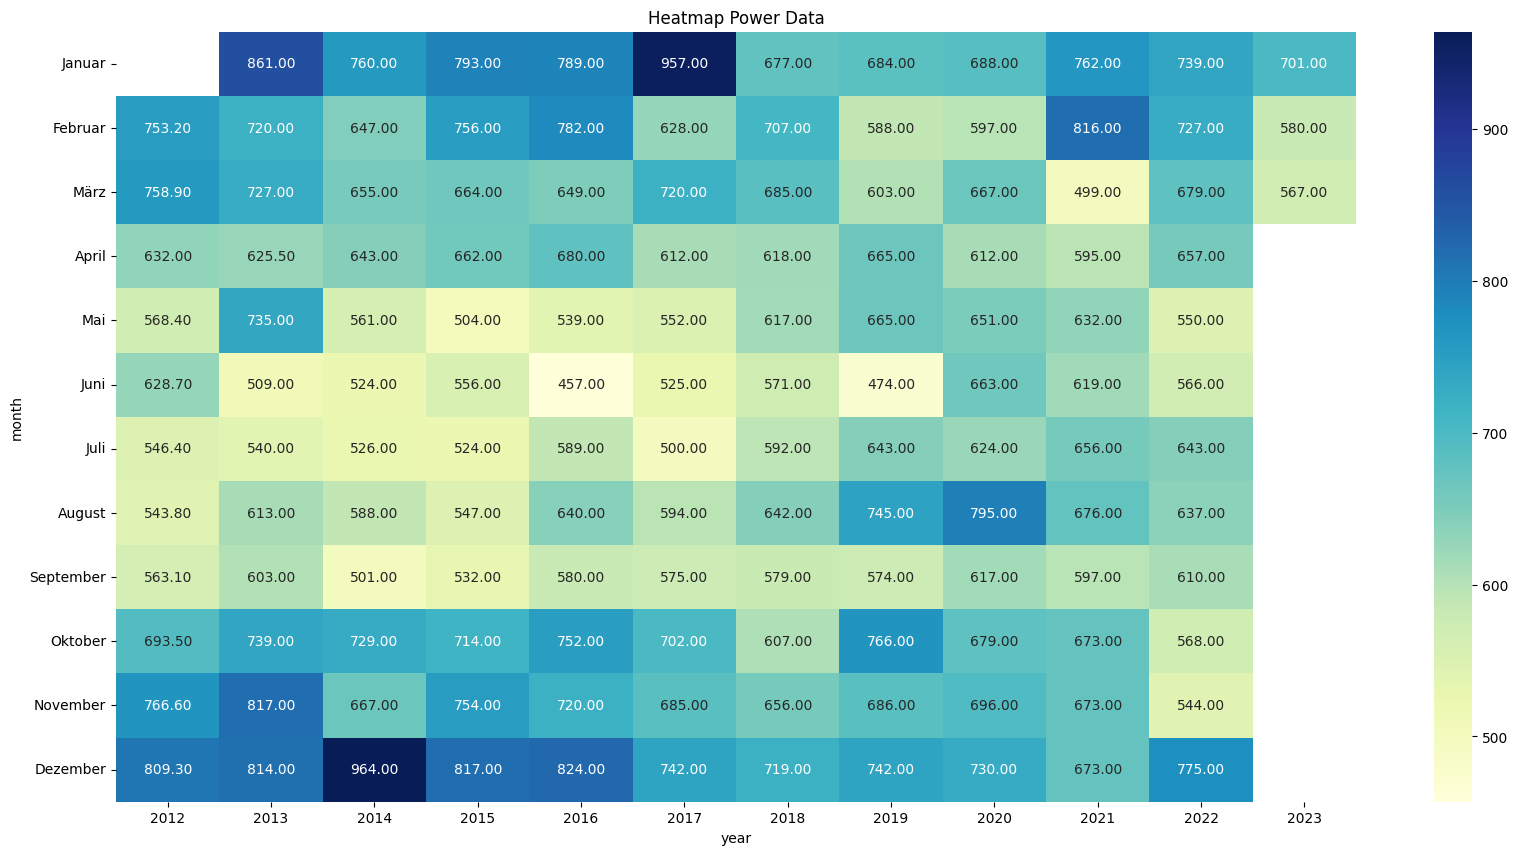

In [19]:
df_heatmap = df_new.pivot(index='month', columns='year', values='power_per_month')
#define the size of the heatmap as width=20 inches and height=10 inches
fig = plt.figure(figsize=(20,10))
ax = sns.heatmap(df_heatmap, cmap='YlGnBu', annot=True, fmt='.2f')
plt.title("Heatmap Power Data")
plt.show()

## Heatmap for the water consumption per month

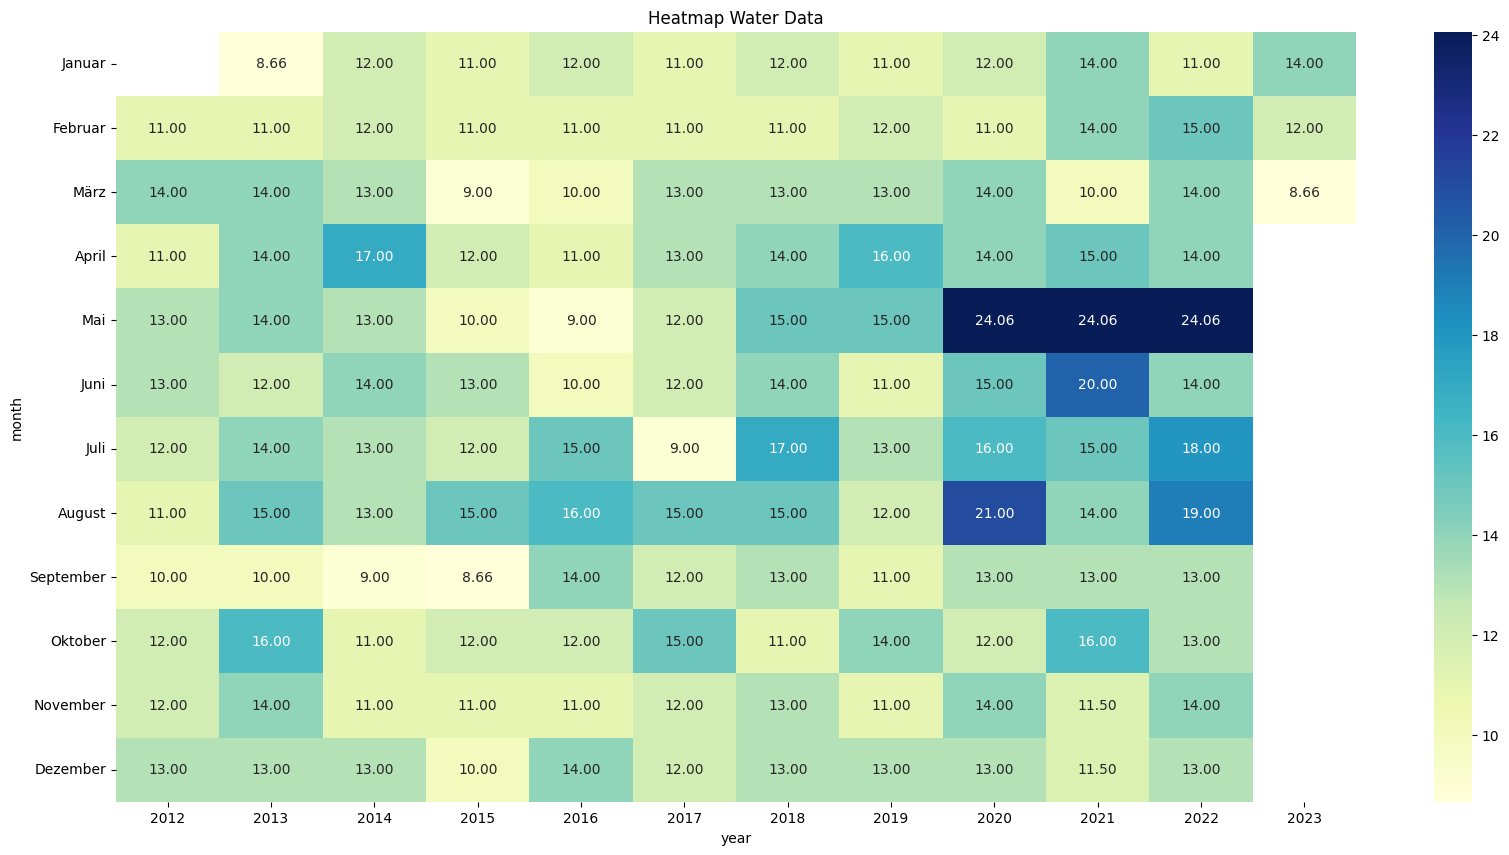

In [20]:
df_heatmap = df_new.pivot(index='month', columns='year', values='water_per_month')
#define the size of the heatmap as width=20 inches and height=10 inches
fig = plt.figure(figsize=(20,10))
ax = sns.heatmap(df_heatmap, cmap='YlGnBu', annot=True, fmt='.2f')
plt.title("Heatmap Water Data")
plt.show()

## Heatmap for water consumption per person per month

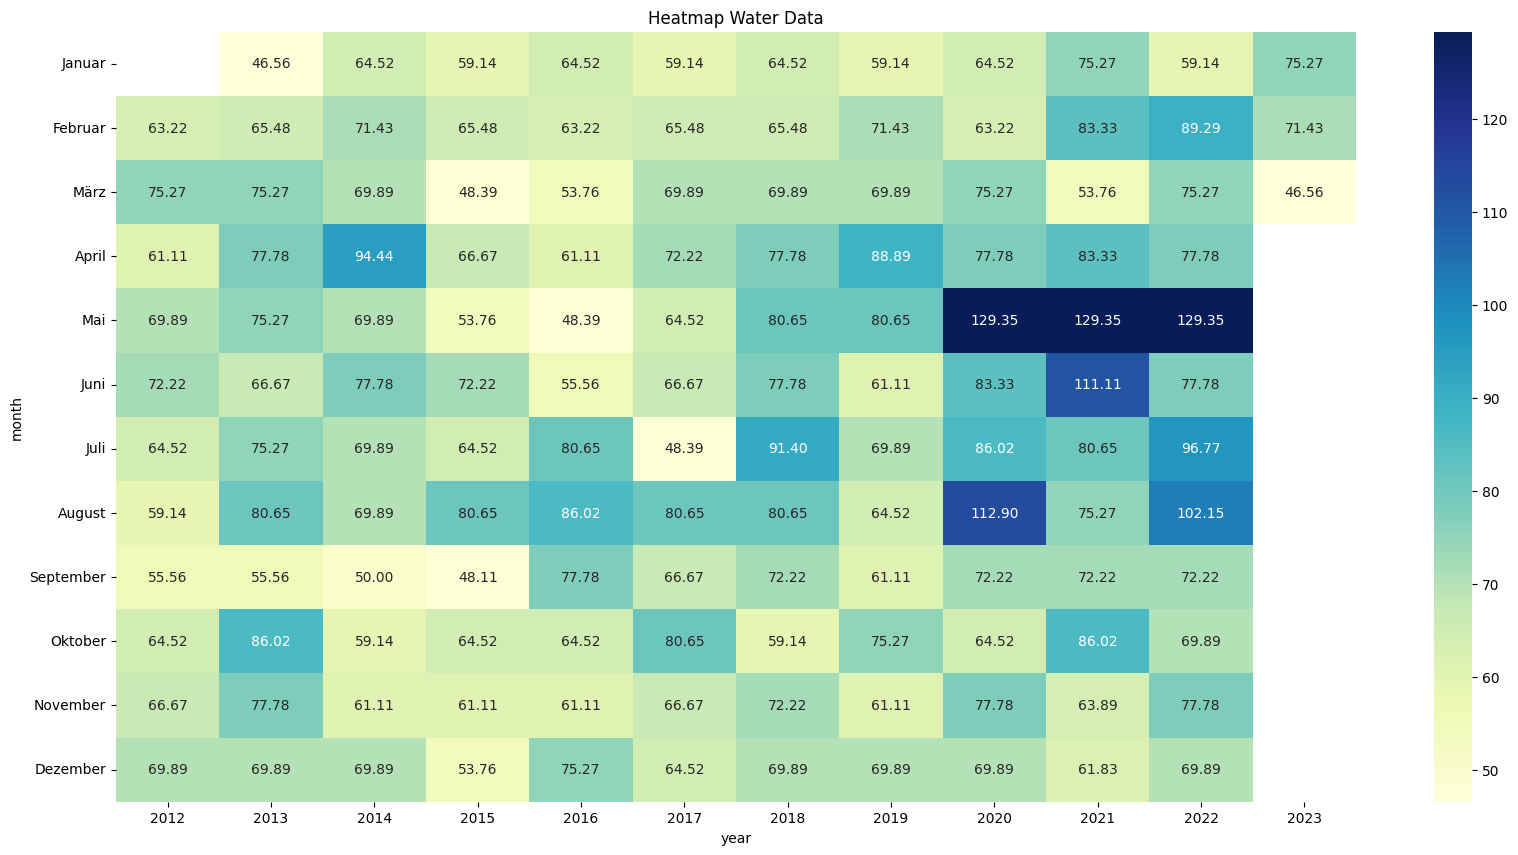

In [21]:
# get the number of days for each month
df_new['days'] = df_new['date'].dt.daysinmonth
#add a new column 'water_per_person' to df_new, which is calculated by dividing the water consumption by the number of people living in the house and the number of days in the month, multiplied by 1000 to get the water consumption in liters per person per day
df_new['water_per_person'] = (df_new['water_per_month'] / 6 / df_new['days']) * 1000
df_heatmap = df_new.pivot(index='month', columns='year', values='water_per_person')
#define the size of the heatmap as width=20 inches and height=10 inches
fig = plt.figure(figsize=(20,10))
ax = sns.heatmap(df_heatmap, cmap='YlGnBu', annot=True, fmt='.2f')
plt.title("Heatmap Water Data")
plt.show()

## Heatmap for the boiler runtime per month

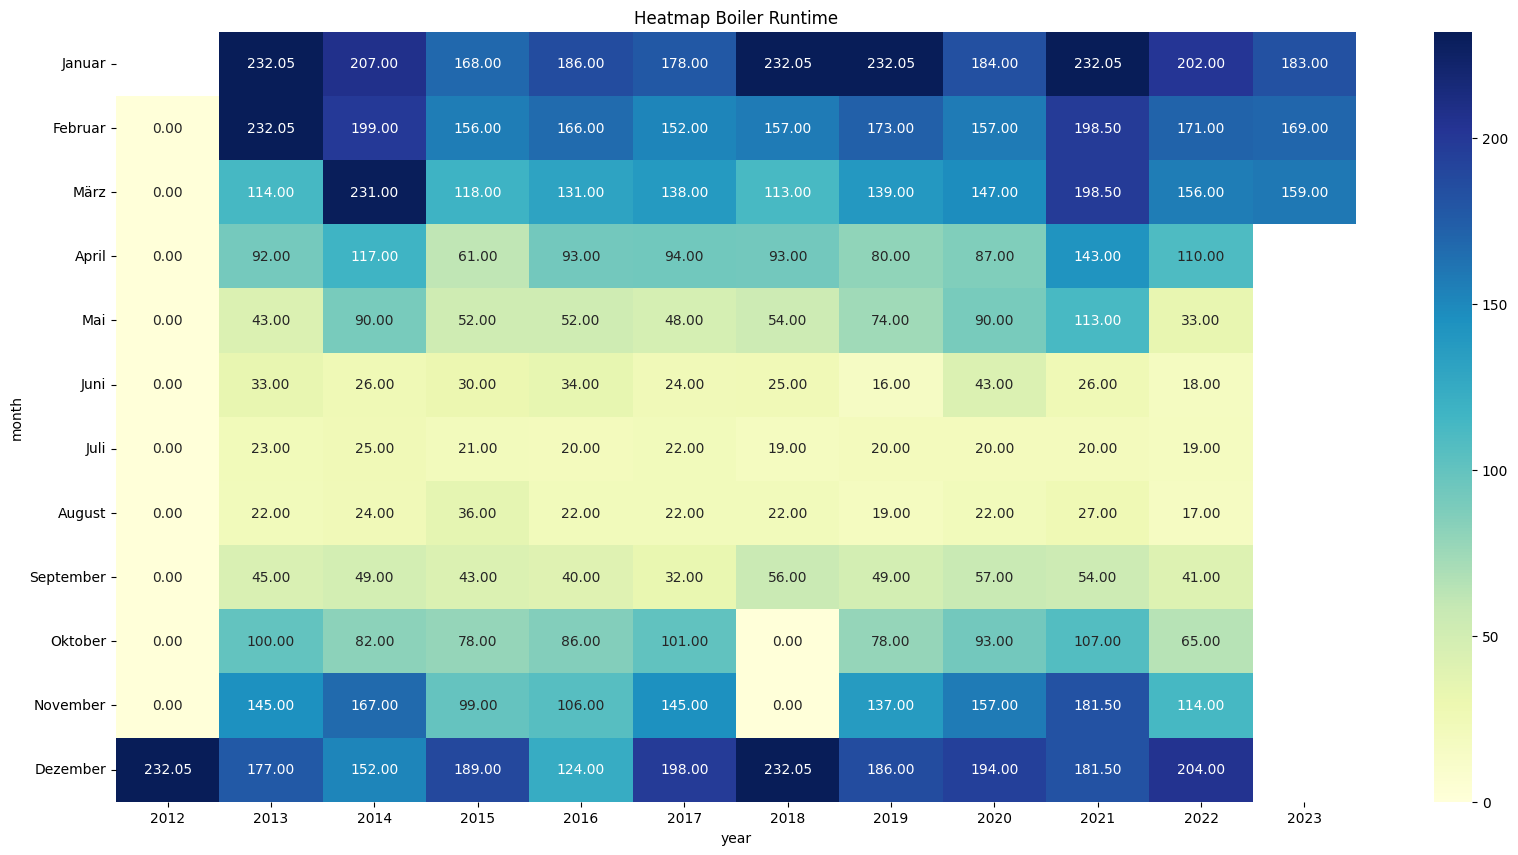

In [22]:
df_heatmap = df_new.pivot(index='month', columns='year', values='boiler_per_month')
#define the size of the heatmap as width=20 inches and height=10 inches
fig = plt.figure(figsize=(20,10))
ax = sns.heatmap(df_heatmap, cmap='YlGnBu', annot=True, fmt='.2f')
plt.title("Heatmap Boiler Runtime")
plt.show()

## Power consumption per year

In [23]:
# print out a table with the total power consumption (power_per_momth) per year
print(df_new.groupby('year')['power_per_month'].sum())
# print the mean value of the power consumption per year
print((df_new.groupby('year')['power_per_month'].sum()).mean())
# print the standard deviation of the power consumption per year
#print(df_new.groupby('year')['power_per_month'].std())
# print the median value of the power consumption per year
#print(df_new.groupby('year')['power_per_month'].median())
# print the minimum value of the power consumption per year
#print(df_new.groupby('year')['power_per_month'].min())
# print the maximum value of the power consumption per year
#print(df_new.groupby('year')['power_per_month'].max())




year
2012    7263.9
2013    8303.5
2014    7765.0
2015    7823.0
2016    8001.0
2017    7792.0
2018    7670.0
2019    7835.0
2020    8019.0
2021    7871.0
2022    7695.0
2023    1848.0
Name: power_per_month, dtype: float64
7323.866666666666


## Water consumption per year

In [24]:
# print out a table with the total power consumption (power_per_momth) per year
print(df_new.groupby('year')['water_per_month'].sum())
#print(df_new.groupby('year').sum('power_per_month'))


year
2012    132.00
2013    155.66
2014    151.00
2015    134.66
2016    145.00
2017    147.00
2018    161.00
2019    152.00
2020    179.06
2021    178.06
2022    182.06
2023     34.66
Name: water_per_month, dtype: float64


## Boiler Runtime per year

In [25]:
print(df_new.groupby('year')['boiler_per_month'].sum())


year
2012     232.05
2013    1258.10
2014    1369.00
2015    1051.00
2016    1060.00
2017    1154.00
2018    1003.10
2019    1203.05
2020    1251.00
2021    1482.05
2022    1150.00
2023     511.00
Name: boiler_per_month, dtype: float64
